# Validation of the PyPSA-Africa generation by hydro powerplants

This notebooks investigates the total energy generation by hydro powerplants by the workflow

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. The solved network is required as the total generation dispatch of the optimized network is considered. 

## Load python imports

In [138]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

# plotting settings
max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

## Load network

Load the PyPSA sovled network

In [139]:
network = "C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_all_ec_lcopt_1h.nc" # change for desired network

n = pypsa.Network(network)

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


## Calculate total hydro energy production by powerplants

Total energy production by dams [TWh]

In [140]:
hydroenergy_by_dams = n.storage_units_t.p.mean().sum() / 1000000 * 8760
hydroenergy_by_dams

0.6831215262323674

Total energy production by run-of-river [TWh]

In [141]:
ror_gen_index = n.generators[n.generators.carrier == "ror"].index
hydroenergy_by_ror = n.generators_t.p[ror_gen_index].mean().sum() / 1000000 * 8760
hydroenergy_by_ror

2.3351525776612236

In [142]:
n.storage_units_t.keys()

dict_keys(['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'marginal_cost', 'marginal_cost_quadratic', 'state_of_charge_set', 'efficiency_store', 'efficiency_dispatch', 'standing_loss', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 'mu_lower', 'mu_state_of_charge_set', 'mu_energy_balance'])

Total hydropower energy production [TWh]

In [143]:
tot_hydroenergy = hydroenergy_by_dams + hydroenergy_by_ror
tot_hydroenergy

3.018274103893591

## Validation of the data with respect to IRENA

The data are compared to [IRENA 2016](https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2016/IRENA_RE_Statistics_2016.pdf) and [IEA 2019](https://www.iea.org/regions/africa)
In particular, the following hydropower generation is expected:

| Source | Tanzania (2013) | Africa (2013) |
|--------|----------------|---------------|
| [IRENA 2016](https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2024/Jul/IRENA_Renewable_Energy_Statistics_2024.pdf) | 2.591 TWh | 122.34 TWh |
| [IEA 2019](https://www.iea.org/regions/africa) | 2.9 TWh | 120.52 TWh |

Print PyPSA result

In [144]:
print("| Source    |   Tanzania (2013)   |")
print("|IRENA 2024|2.63 TWh|----------------|")
print("|IEA 2019|2.9 TWh|----------------|")
print(
    "| PyPSA     |      %.2f TWh     |"
    % (tot_hydroenergy)
)

| Source    |   Tanzania (2013)   |
|IRENA 2024|2.63 TWh|----------------|
|IEA 2019|2.9 TWh|----------------|
| PyPSA     |      3.02 TWh     |


Installed capacity

In [145]:

# Installed capacity of hydro reservoirs in MW
reservoir_capacity = n.storage_units.p_nom.sum() 
reservoir_capacity




2482.8662420382166

In [146]:
#installed capacity ror in MW
ror_gen_index = n.generators[n.generators.carrier == "ror"].index
ror_capacity = n.generators.p_nom[ror_gen_index].sum()  # Sum the nominal capacities
ror_capacity


267.12597159415475

In [147]:
tot_hydro_capacity = ror_capacity + reservoir_capacity
tot_hydro_capacity

2749.992213632371

In [148]:
# Filter storage units operational in 2013
storage_units_2013 = n.storage_units[
    (n.storage_units.build_year <= 2013)]


# Sum the installed capacity for 2013- NOT CORRECT- the installed capacity was not that hight in 2013
reservoir_capacity_2013 = storage_units_2013.p_nom.sum()
print(f"Installed capacity of hydro reservoirs in 2013: {reservoir_capacity_2013:.2f} MW")

Installed capacity of hydro reservoirs in 2013: 2482.87 MW


## Validation of the data with respect to IRENA

The data are compared to [IRENA 2024](https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2024/Jul/IRENA_Renewable_Energy_Statistics_2024.pdf) and [IEA 2019](https://www.iea.org/regions/africa)
In particular, the following hydropower generation is expected:

| Source | Tanzania (2013) | |
|--------|----------------|---------------|
| [IRENA 2024](https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2024/Jul/IRENA_Renewable_Energy_Statistics_2024.pdf) | 572 MW |  |
| [IEA 2019](https://www.iea.org/regions/africa) | |

Print PyPSA result

In [149]:
print("| Source    |   Tanzania (2039))  |  |")
print(
    "| PyPSA     |      %.2f MW    |     |"
    % (tot_hydro_capacity)
)

| Source    |   Tanzania (2039))  |  |
| PyPSA     |      2749.99 MW    |     |


# Validation of the PyPSA-Tanzania Electric Demand

This notebooks investigates the data quality of the Tanzania electric consumption
data by comparing PyPSA, official Nigerian and Our World in Data (incl. BP & Ember).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Tanzania

In [150]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Our World in Data
Retrieved from their GitHub: https://github.com/owid/energy-data/tree/master /
Web interface: https://ourworldindata.org/energy 

Our data sources:
- Energy consumption (primary energy, energy mix and energy intensity): this data is sourced from a combination of three sources—the BP Statistical Review of World Energy, the EIA and the SHIFT Data Portal.
- Electricity generation (electricity generation, and electricity mix): this data is sourced from a combination of three sources—the BP Statistical Review of World Energy, the Ember – Data Explorer and the Ember European Electricity Review.
- Other variables: this data is collected from a variety of sources (United Nations, World Bank, Gapminder, Maddison Project Database, etc.). More information is available in our codebook.

In [151]:
url = "https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv"
df = pd.read_csv(url)

# Select relevant columns
df = df.loc[:, ["iso_code", "country", "year", "electricity_demand", "electricity_generation"]]

# Filter for Tanzania (iso_code == "TZA")
df = df[df["iso_code"] == "TZA"]

# Assign to electricity_demand_owid
electricity_demand_owid = df

# Display the last two rows
electricity_demand_owid.tail(2)

,iso_code,country,year,electricity_demand,electricity_generation
19072,TZA,Tanzania,2021,8.81,8.67
19073,TZA,Tanzania,2022,9.17,9.02


PyPSA network

In [ ]:

pypsa_network = n

year='2013'
# Filter the load data for the year 2013
electricity_demand_pypsa = pypsa_network.loads_t.p_set.loc[year]

# Calculate the total load (sum across all time steps and buses)
total_load = electricity_demand_pypsa.sum().sum()

# Convert from MW to TWh (if needed)
total_load_twh = total_load / 1e6  # Convert MW to TWh

# Display the total load
print(f"Total electricity demand in {year} (PyPSA network): {total_load_twh:.2f} TWh")


Total electricity demand in 2013 (PyPSA network): 10.44 TWh


# 2. Validate

#### Steps:
- Align country coverage of dataframe
- Pick year of interest for 'Our World in Data'
- Align dataframe naming and temporal resolution
- Merge dataframe


In [ ]:


#Total electric demand in twh

year_owid = 2013  # option

df = df[df["year"] == year_owid]
electricity_demand_owid_mini = df
electricity_demand_owid_mini.head(2)

,iso_code,country,year,electricity_demand,electricity_generation
19064,TZA,Tanzania,2013,6.05,5.99


C:\Users\hie\AppData\Local\Temp\ipykernel_27776\2747710309.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



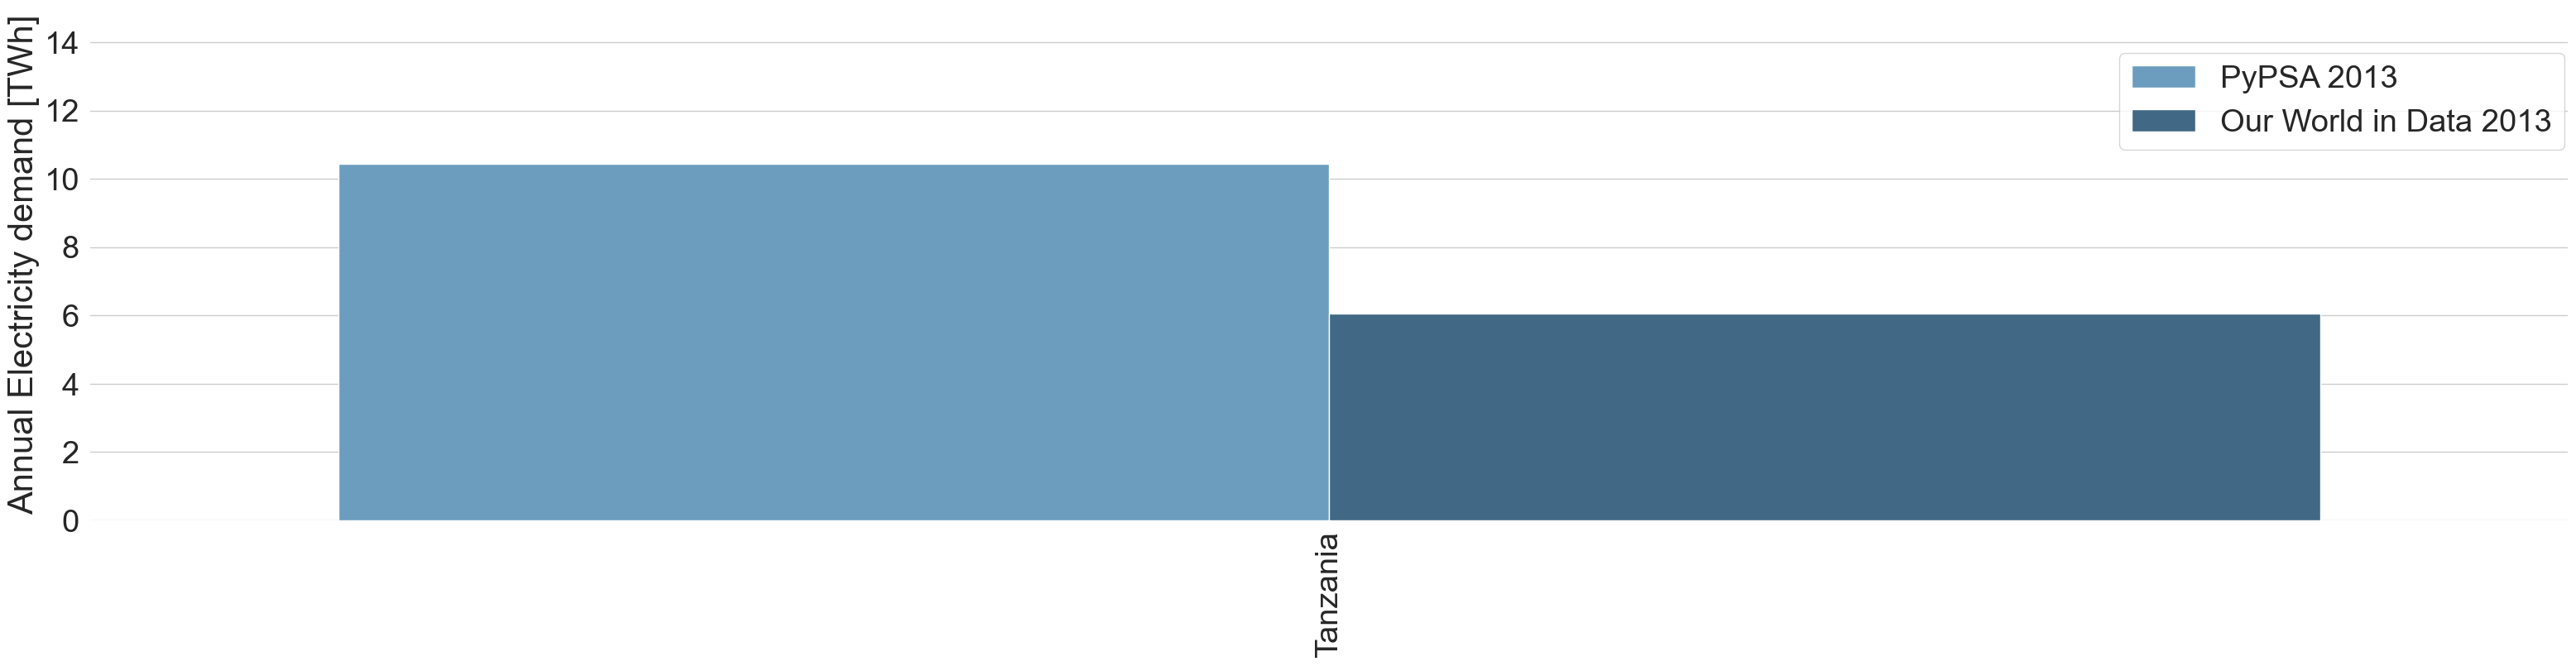

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid", font_scale=2.5)

# Convert total_load_twh to a DataFrame
total_load_twh_df = pd.DataFrame(
    {
        "country": ["Tanzania"],
        "year": [2013],
        "electricity_demand": [total_load_twh],  # Use the scalar value
        "source": [f"PyPSA 2013"],
    }
)

# Add source information to OWID data
electricity_demand_owid_mini["source"] = f"Our World in Data {year_owid}"

# Merge the two DataFrames
df_merge = pd.concat([total_load_twh_df, electricity_demand_owid_mini])

ax = sns.catplot(
    x="country",
    y="electricity_demand",
    hue="source",
    data=df_merge,
    palette="Blues_d",
    kind="bar",
    height=8,
    aspect=4,
)
ax.set_xticklabels(rotation=90)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.85, 0.9), frameon=True, title=None)
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="Annual Electricity demand [TWh]", ylim=(0, 15))
#ax.savefig("demand-validation-part1.pdf", bbox_inches="tight")

,source,country,electricity_demand,iso_code,electricity_generation
0,Our World in Data 2013,Tanzania,6.050000,TZA,5.99
1,PyPSA 2013,Tanzania,10.440527,0,0.00
0,IRENA 2030,NaN,1924.000000,NaN,NaN
1,Alova et al. 2030,NaN,1877.000000,NaN,NaN


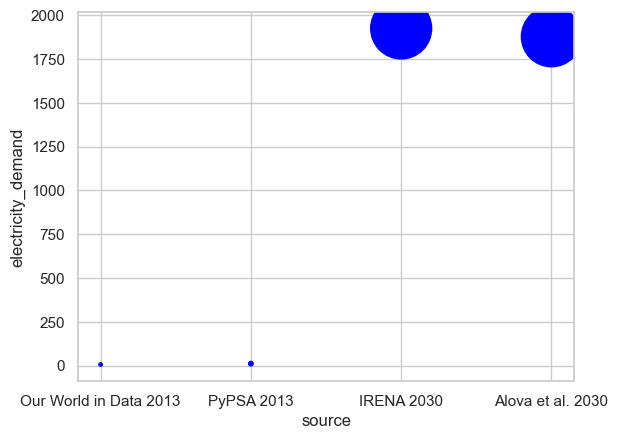

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1)

african_total_consumption = (
    df_merge.groupby(by="source").sum().drop(columns="year").reset_index()
)
extra = pd.DataFrame(
    data={
        "source": ["IRENA 2030", "Alova et al. 2030"],
        "electricity_demand": [1004 + 920, 1877],
    }
)
# https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2015/IRENA_Africa_2030_REmap_2015_low-res.pdf
# https://www.nature.com/articles/s41560-020-00755-9

african_total_consumption = pd.concat([african_total_consumption, extra])
african_total_consumption.plot.scatter(
    x="source", y="electricity_demand", s="electricity_demand"
)
african_total_consumption